## Dataset loading and prepping

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
import matplotlib.pyplot as plt

#Load the csv files into dataframes
df_classes = pd.read_csv('elliptic_txs_classes.csv')
df_edges = pd.read_csv('elliptic_txs_edgelist.csv')
df_features = pd.read_csv('elliptic_txs_features.csv', header=None)

In [2]:
#Rename the feature df's column headers
df_features.columns = ['txId', 'timestep'] + [f'transaction_feat_{i}' for i in range(2,95)] + [f'aggr_feat_{i}' for i in range(1,73)]

#Merge the classes df with the features df
df_features = pd.merge(df_features, df_classes, left_on='txId', right_on='txId', how='left')

#Remove the unknown transactions and combine the illicit and suspisious transactions
df_features = df_features.drop(df_features[df_features['class'] == 'unknown'].index)
timesteps_to_remove = [48, 49]
df_features= df_features.drop(df_features[df_features['timestep'].isin(timesteps_to_remove)].index)
df_features['class'] = df_features['class'].replace({'1':1, 'suspicious':1 , '2':0})

#df_features.groupby('timestep').size()

C:\Users\there\AppData\Local\Temp\ipykernel_3132\1987003630.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_features['class'] = df_features['class'].replace({'1':1, 'suspicious':1 , '2':0})


## Model training

In [3]:
#Splitting the data set
x = df_features.drop(['txId', 'timestep', 'class'], axis =1)
y = df_features['class']
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, random_state=30, shuffle = True, stratify=y)

In [4]:
#Training the model
#rf_Model = RandomForestClassifier(n_estimators=50, max_depth=100, max_features=50, random_state=15)

rf_Model = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=15)

rf_Model.fit(trainX, trainY)
train_pred = rf_Model.predict(trainX)
test_pred = rf_Model.predict(testX)

joblib.dump(rf_Model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4, 5],
    'max_features': ['sqrt', 'log2', 10]  
}

# Perform RandomizedSearchCV for hyperparameter tuning
rf_random = RandomizedSearchCV(estimator=rf_Model, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
rf_random.fit(trainX, trainY)

# Use the best model from the search
best_rf_Model = rf_random.best_estimator_

# Train the model
best_rf_Model.fit(trainX, trainY)

In [5]:
train_pred = rf_Model.predict(trainX)
test_pred = rf_Model.predict(testX)

In [6]:
print('\nClassification Report:')
print(classification_report(testY, test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12349
           1       0.98      0.96      0.97      8816

    accuracy                           0.98     21165
   macro avg       0.98      0.97      0.97     21165
weighted avg       0.98      0.98      0.98     21165



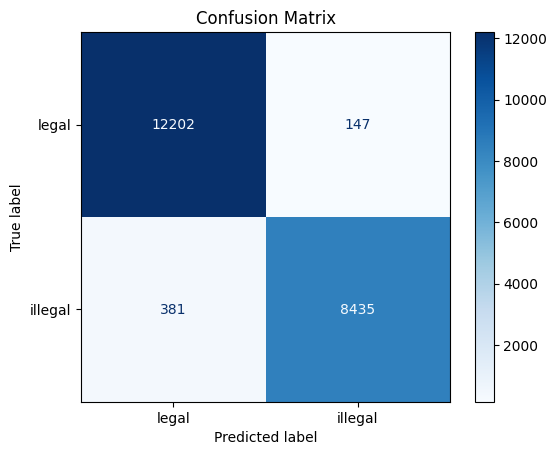

In [7]:
# Generate confusion matrix
cm = confusion_matrix(testY, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['legal', 'illegal'])
# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_Model, trainX, trainY, cv=5, scoring='accuracy', n_jobs=-1)

# Calculate the mean and standard deviation of training/test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="green")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()
